# Оптимизация маркетинговых затрат Яндекс.Афиши

Задача:  

    Провести анализ данных о визитах, заказах и расходах Яндекс.Афиши с целью оптимизации маркетинговых затрат.
    
    Необходимо изучить и найти ответы на следующие вопросы:
    •	как люди пользуются продуктом,
    •	когда они начинают покупать,
    •	сколько денег приносит каждый клиент,
    •	когда клиент окупается.
    
Анализ проводится на основе следующих данных:
 * лог сервера с данными о посещениях сайта Яндекс.Афиши;
 * выгрузка всех заказов за этот период;
 * статистика рекламных расходов.



### План работ
1. [Шаг 1. Загрузка и подготовка данных для анализа](#step1)   
    1.1 [Посещения сайта - visits](#step1.1)  
    1.2 [Заказы - orders](#step1.2)  
    1.3 [Расходы - costs](#step1.3)      
2. [Шаг 2. Построение отчетов и расчет метрик](#step2)   
    2.1 [Исследование продукта](#step2.1)      
      2.1.1 [DAU, WAU, MAU](#step2.1.1)     
      2.1.2 [Пользовательские сессии](#step2.1.2)         
      2.1.3 [Retention rate](#step2.1.3)  
      2.1.4 [Вывод](#step2.1.4)  
    2.2 [Исследование продаж](#step2.2)    
      2.2.1 [Когда люди начинают покупать?](#step2.2.1)    
      2.2.2 [Сколько раз покупают за период?](#step2.2.2)  
      2.2.3 [Какой средний чек?](#step2.2.3)  
      2.2.4 [Сколько денег приносят(LTV)?](#step2.2.4)  
    2.3 [Исследование маркетинга](#step2.3)    
      2.3.1 [Сколько денег потратили?](#step2.3.1)  
      2.3.2 [Сколько стоило привлечение одного покупателя из каждого источника?](#step2.3.2)  
      2.3.3 [Насколько окупились расходы? (ROI)](#step2.3.3)  
      2.3.4 [Вывод](#step2.3.4)  
3.  [Шаг 3. Общий вывод](#step2)   

<a id='step1'></a>
## Шаг 1. Загрузка и подготовка данных для анализа

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as DT

<a id='step1.1'></a>
### Посещения сайта - visits

In [2]:
# Загрузка информации о посещениях сайта Яндекс.Афиши 
visits = pd.read_csv('visits_log.csv')

In [3]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [4]:
# Приведение названий столбцов к корректному формату
visits.columns = ['device', 'session_end', 'source_id', 'session_start', 'user_id']

In [5]:
# Проверка названий столбцов и просмотр информации о таблице
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device           359400 non-null object
session_end      359400 non-null object
source_id        359400 non-null int64
session_start    359400 non-null object
user_id          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [6]:
# Приведение даты начала сессии к типу datetime64
visits['session_start'] = pd.to_datetime(visits['session_start'])

In [7]:
# Приведение даты окончания сессии к типу datetime64
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device           359400 non-null object
session_end      359400 non-null datetime64[ns]
source_id        359400 non-null int64
session_start    359400 non-null datetime64[ns]
user_id          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [9]:
# Проверка наличия дубликатов
visits.duplicated().sum()

0

In [10]:
# Проверка данных в столбце device
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [11]:
# Определение периода в таблице с информацией о сессиях пользователей
visits['session_start'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: session_start, dtype: object

In [12]:
# Итоговая проверка таблицы
visits.head()

,device,session_end,source_id,session_start,user_id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


**Вывод**: 
1. В таблице `visits` записаны данные о пользовательских сессиях за год (с **01.06.2017** по **31.05.2018**).
2. Наименования столбцов исправлены и приведены к корректному формату:  
    Uid —> `user_id`,  
    Device —> `device`,  
    Start Ts —> `session_start`,  
    End Ts —> `session_end`,  
    Source Id —> `source_id`.  
3. Даты в таблице приведены к типу данных `datetime64`.
4. Пустых значений и дубликатов в таблице не выявлено.

<a id='step1.2'></a>
### Заказы - orders

In [13]:
# Загрузка информации о всех заказах
orders = pd.read_csv('orders_log.csv')

In [14]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [15]:
# Приведение названий столбцов к корректному формату
orders.columns = ['order_date', 'revenue', 'user_id']

In [16]:
# Проверка названий столбцов и просмотр информации о таблице
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_date    50415 non-null object
revenue       50415 non-null float64
user_id       50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [17]:
# Приведение даты заказа к типу datetime64
orders['order_date'] = pd.to_datetime(orders['order_date'])

In [18]:
# Проверка
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_date    50415 non-null datetime64[ns]
revenue       50415 non-null float64
user_id       50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [19]:
# Проверка наличия дубликатов
orders.duplicated().sum()

0

In [20]:
# Проверка периода в таблице с информацией о заказах
orders['order_date'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: order_date, dtype: object

In [21]:
# Проверка итоговой таблицы
orders.head()

,order_date,revenue,user_id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


**Вывод**: 
1. В таблице `orders` записаны данные о всех заказ пользователей за год (с **01.06.2017** по **01.06.2018**).
2. Наименования столбцов исправлены и приведены к корректному формату:  
    Buy Ts —> `order_date`,  
    Revenue —> `revenue`,  
    Uid —> `user_id`,   
3. Даты в таблице приведены к типу данных `datetime64`.
4. Пустых значений и дубликатов в таблице не выявлено.

<a id='step1.3'></a>
### Расходы - costs

In [22]:
# Загрузка информации о рекламных расходах
costs  = pd.read_csv('costs.csv')

In [23]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [24]:
# Просмотр общей информации о таблице
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [25]:
# Приведение даты затрат к типу datetime64
costs['dt'] = pd.to_datetime(costs['dt'])

In [26]:
# Проверка
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [27]:
# Проверка наличия дубликатов
costs.duplicated().sum()

0

In [28]:
# Проверка периода в таблице с информацией о затратах
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

**Вывод**: 
1. В таблице `costs` записаны данные о затратах на маркетинг за год (с **01.06.2017** по **31.05.2018**).
2. Даты в таблице приведены к типу данных `datetime64`.
3. Пустых значений и дубликатов в таблице не выявлено.

<a id='step2'></a>
## Шаг 2. Построение отчетов и расчет метрик

<a id='step2.1'></a>
### Исследование продукта

<a id='step2.1.1'></a>
### Сколько людей пользуются в день (DAU), неделю (WAU), месяц (MAU)? 

In [29]:
# Таблица с посещениями
visits.sample(5)

,device,session_end,source_id,session_start,user_id
91022,desktop,2018-01-03 22:24:00,4,2018-01-03 22:23:00,2114719842084541814
56597,desktop,2017-10-17 10:19:00,4,2017-10-17 10:16:00,15810648912357305308
12148,desktop,2018-05-28 08:13:00,5,2018-05-28 07:46:00,5230288913288523701
239230,touch,2018-01-02 10:55:00,4,2018-01-02 10:38:00,8429247955541023770
98955,touch,2018-04-30 21:50:00,4,2018-04-30 21:33:00,4021049237687073841


In [30]:
# Выделение даты, года, месяца, недели в отдельные столбцы
visits['session_date'] = visits['session_start'].dt.date
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].astype('datetime64[M]')
visits['session_week'] = visits['session_start'].dt.week

In [31]:
# Проверка
visits.head()

,device,session_end,source_id,session_start,user_id,session_date,session_year,session_month,session_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,2017-12-01,51
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2018-02-01,8
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,2017-07-01,26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,2018-05-01,20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,2017-12-01,52


#### DAU

In [32]:
# Расчет количества пользователей в день
dau = visits.groupby('session_date')['user_id'].nunique()

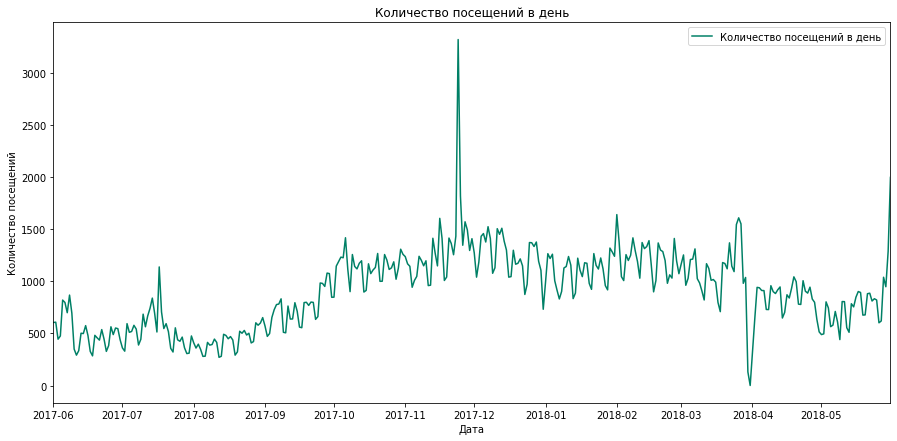

In [33]:
# График количества посещений сайта в день
dau.plot(figsize =(15, 7), colormap='summer')

plt.title('Количество посещений в день')
plt.xlabel('Дата')
plt.ylabel('Количество посещений')
plt.legend(['Количество посещений в день'])
plt.show()

In [34]:
# День максимального количества посещений в день
dau.idxmax()

datetime.date(2017, 11, 24)

In [35]:
# День минимального количества посещений в день
dau.idxmin()

datetime.date(2018, 3, 31)

Видим всплеск 24 ноября 2017 года. В этот день в России проходила "Черная пятница". Можно предположить, что акции, проводимые в "Черную пятницу" работают и привлекают больше пользователей, чем в остальные дни.  
Минимальное количество посетителей было зафиксировано 31 марта 2018 года. Возможно, в этот день произошел какой-то технический сбой.

In [36]:
dau = dau.reset_index()

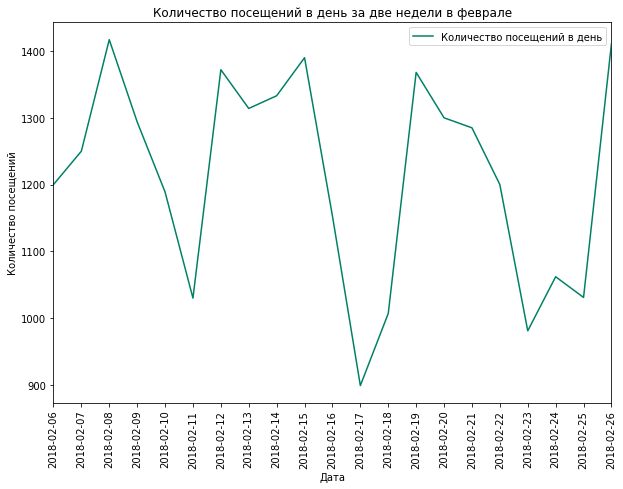

In [37]:
# Масштабирование графика: посмотрим тендецию по количеству пользователей на двух неделях в феврале
dau_week_slice = dau[(dau['session_date'] >= DT.datetime.strptime('2018-02-06', '%Y-%m-%d').date()) & 
                     (dau['session_date'] <= DT.datetime.strptime('2018-02-26', '%Y-%m-%d').date())]
dau_week_slice.plot(x = 'session_date', 
                    y = 'user_id', 
                    colormap='summer',
                    figsize = (10, 7))

plt.title('Количество посещений в день за две недели в феврале')
plt.xlabel('Дата')
plt.ylabel('Количество посещений')
plt.legend(['Количество посещений в день'])
plt.xticks(dau_week_slice['session_date'], rotation=90)
plt.show()

Можно заметить, что посещение сайта волнообразно: количество уникальных пользователей снижается к концу недели и резко возрастает начиная с воскресенья.

In [38]:
# Среднее количество пользователей в день
round(dau['user_id'].median())

921.0

#### WAU

In [39]:
# Расчет количества пользователей в неделю
wau = visits.groupby(['session_year', 'session_week'])['user_id'].nunique()

In [40]:
# Разброс количества пользователей в неделю
wau.describe()

count       53.000000
mean      5716.245283
std       2049.898027
min       2021.000000
25%       4128.000000
50%       5740.000000
75%       7401.000000
max      10586.000000
Name: user_id, dtype: float64

In [41]:
# Среднее количество пользователей в неделю
round(wau.median())

5740.0

#### MAU

In [42]:
# Расчет количества пользователей в месяц
mau = visits.groupby(['session_year', 'session_month'])['user_id'].nunique()

In [43]:
mau.describe()

count       12.000000
mean     23228.416667
std       7546.380462
min      11631.000000
25%      17777.000000
50%      24240.500000
75%      28984.750000
max      32797.000000
Name: user_id, dtype: float64

In [44]:
# Среднее количество пользователей в месяц
round(mau.median())

24240.0

#### Sticky Factor

In [45]:
# Расчет недельного sticky factor
round(dau.median()) / round(wau.median()) * 100

user_id    16.045296
dtype: float64

In [46]:
# Расчет месячного sticky factor
round(dau.median()) / round(mau.median()) * 100

user_id    3.799505
dtype: float64

#### Количество пользователей в разбивке по устройствам

In [47]:
# Общее количество пользователей
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [48]:
# Срез для посещений с устройствами типа desktop
desktop = visits[visits['device'] == 'desktop']

In [49]:
# Срез для посещений с устройствами типа touch
touch = visits[visits['device'] == 'touch']

In [50]:
# Ежедневное, еженедельное и ежемесяное количество пользователей с десктопными устройствами
print('Пользователи с типом устройств desktop:')
print('DAU:', (desktop.groupby('session_date')['user_id'].nunique()).median())
print('WAU:', (desktop.groupby(['session_year', 'session_week'])['user_id'].nunique()).median())
print('MAU:', (desktop.groupby('session_month')['user_id'].nunique()).median())

print('Недельный sticky factor: {:.2%}'.format((desktop.groupby('session_date')['user_id'].nunique()).median()
                                               /(desktop.groupby(['session_year', 'session_week'])['user_id'].nunique()).median()))
print('Недельный sticky factor: {:.2%}'.format((desktop.groupby('session_date')['user_id'].nunique()).median()
                                               /(desktop.groupby(['session_month'])['user_id'].nunique()).median()))

Пользователи с типом устройств desktop:
DAU: 649.0
WAU: 4061.0
MAU: 17209.0
Недельный sticky factor: 15.98%
Недельный sticky factor: 3.77%


In [51]:
# Ежедневное, еженедельное и ежемесяное количество пользователей с мобильными устройствами типа touch
print('Пользователи с типом устройств touch:')
print('DAU:', (touch.groupby('session_date')['user_id'].nunique()).median())
print('WAU:', (touch.groupby(['session_year', 'session_week'])['user_id'].nunique()).median())
print('MAU:', (touch.groupby('session_month')['user_id'].nunique()).median())

print('Недельный sticky factor: {:.2%}'.format((touch.groupby('session_date')['user_id'].nunique()).median()
                                               /(touch.groupby(['session_year', 'session_week'])['user_id'].nunique()).median()))
print('Недельный sticky factor: {:.2%}'.format((touch.groupby('session_date')['user_id'].nunique()).median()
                                               /(touch.groupby(['session_month'])['user_id'].nunique()).median()))

Пользователи с типом устройств touch:
DAU: 264.0
WAU: 1724.0
MAU: 7475.0
Недельный sticky factor: 15.31%
Недельный sticky factor: 3.53%


<a id='step2.1.2'></a>
### Пользовательские сессии

#### Сколько сессий в день?

In [52]:
# Расчет количества сессий и количества пользователей в день
user_sessions_per_day = visits.groupby('session_date').agg({'user_id':['count', 'nunique']})

In [53]:
user_sessions_per_day.head()

user_id        
               count nunique
session_date                
2017-06-01       664     605
2017-06-02       658     608
2017-06-03       477     445
2017-06-04       510     476
2017-06-05       893     820

In [54]:
# Расчет среднего количества сессий на пользователя в день
avg_user_sessions_per_day = user_sessions_per_day[('user_id', 'count')] / user_sessions_per_day[('user_id', 'nunique')]

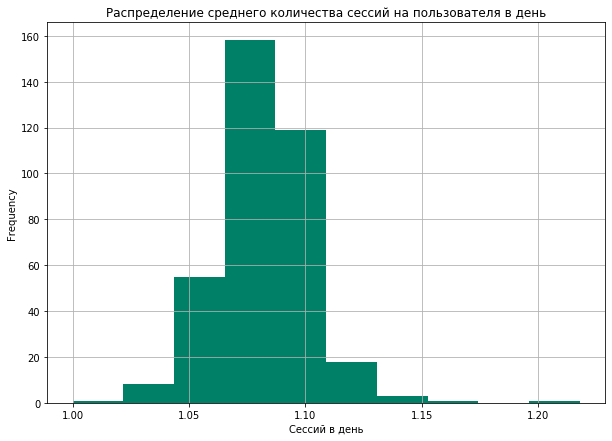

In [55]:
# Распределение среднего количества сессий на пользователя в день
avg_user_sessions_per_day.plot(kind = 'hist',
                               figsize = (10, 7),
                               grid = True,
                               colormap ='summer')

plt.title('Распределение среднего количества сессий на пользователя в день')
plt.xlabel('Сессий в день')
plt.show()

In [56]:
# Среднее количество сессий в день для всех пользователей
avg_user_sessions_per_day.mean()

1.082169644003972

In [57]:
# Расчет количества сессий и количества пользователей для десктопных устройств
user_sessions_per_day_desktop = desktop.groupby('session_date').agg({'user_id':['count', 'nunique']})

In [58]:
# Расчет количества сессий и количества пользователей для мобильных устройств
user_sessions_per_day_touch = touch.groupby('session_date').agg({'user_id':['count', 'nunique']})

In [59]:
# Расчет среднего количества сессий на пользователя в день для десктопных устройств
(user_sessions_per_day_desktop[('user_id', 'count')] / user_sessions_per_day_desktop[('user_id', 'nunique')]).mean()

1.0889553115247612

In [60]:
# Расчет среднего количества сессий на пользователя в день для мобильных устройств
(user_sessions_per_day_touch[('user_id', 'count')] / user_sessions_per_day_touch[('user_id', 'nunique')]).mean()

1.0510715741665035

#### Сколько длится одна сессия (ASL)? 

In [61]:
asl = (visits['session_end'] - visits['session_start']).dt.seconds

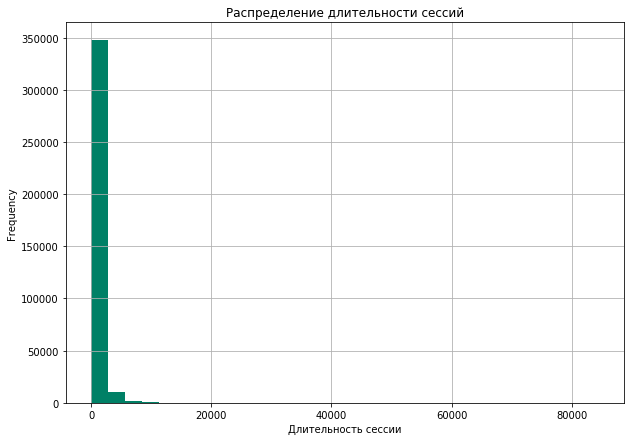

In [62]:
# Распределение длительности сессий
asl.plot(kind = 'hist',
         figsize = (10, 7),
         grid = True,
         colormap ='summer',
         bins = 30)

plt.title('Распределение длительности сессий')
plt.xlabel('Длительность сессии')
plt.show()

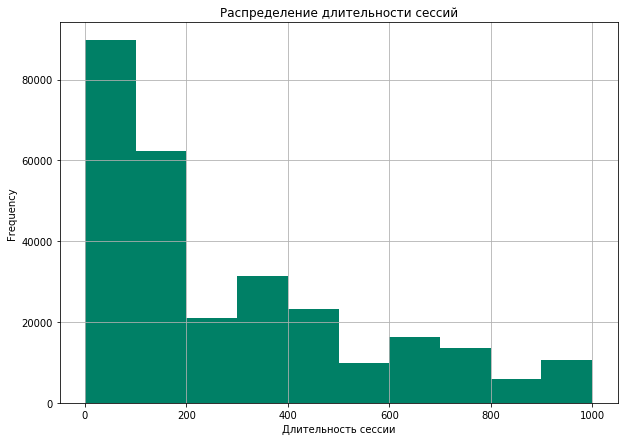

In [63]:
# Распределение длительности сессий в промежутке до 1000 сек
asl.plot(kind = 'hist',
         figsize = (10, 7),
         grid = True,
         range = (0,1000),
         colormap ='summer')

plt.title('Распределение длительности сессий')
plt.xlabel('Длительность сессии')
plt.show()

На графике видны аномалии - по всей видимости, "подвисшие" сессии, не отражающие реальные данные.

In [64]:
# Средняя продолжительность сессии в секундах
asl.median()

300.0

In [65]:
# Самое часто встречающееся значение продолжительности сессии в секундах
asl.mode()

0    60
dtype: int64

In [66]:
# Средняя продолжительность сессии в секундах для десктопных устройств
(desktop['session_end'] - desktop['session_start']).dt.seconds.median()

360.0

In [67]:
# Средняя продолжительность сессии в секундах для мобильных устройств
(touch['session_end'] - touch['session_start']).dt.seconds.median()

180.0

<a id='step2.1.3'></a>
### Коэффициент удержания клиентов (retention rate)

Т.к. месячный sticky factor был достаточно низкий (3,7%), то формировать когорты для нахождения retention rate будем по месяцам.

In [68]:
# Определение первой даты активности пользователя
first_activity_date = visits.groupby(['user_id'])['session_start'].min().dt.date

In [69]:
# Переименование series для объединения с visits
first_activity_date.name = 'first_activity_date'

In [70]:
first_activity_date.head()

user_id
11863502262781     2018-03-01
49537067089222     2018-02-06
297729379853735    2017-06-07
313578113262317    2017-09-18
325320750514679    2017-09-30
Name: first_activity_date, dtype: object

In [71]:
# Присоединение первой даты активности пользователя к таблице с посещениями
visits = visits.join(first_activity_date, on = 'user_id') 

In [72]:
# Проверка
visits.head()

,device,session_end,source_id,session_start,user_id,session_date,session_year,session_month,session_week,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,2017-12-01,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2018-02-01,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,2017-07-01,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,2018-05-01,20,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,2017-12-01,52,2017-12-27


In [73]:
# Выделение месяца из first_activity_date 
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

In [74]:
# Расчет lifetime для каждой сессии
visits['cohort_lifetime'] = (visits['session_month'] - visits['first_activity_month'])/np.timedelta64(1,'M')

In [75]:
# Приведение к целочисленному типу данных
visits['cohort_lifetime'] = round(visits['cohort_lifetime']).astype('int') 

In [76]:
# Проверка
visits.sample(3)

,device,session_end,source_id,session_start,user_id,session_date,session_year,session_month,session_week,first_activity_date,first_activity_month,cohort_lifetime
133404,desktop,2017-09-12 11:59:00,2,2017-09-12 11:47:00,18349197036303577476,2017-09-12,2017,2017-09-01,37,2017-06-19,2017-06-01,3
97201,touch,2017-11-28 17:40:00,2,2017-11-28 17:36:00,9710004212512529070,2017-11-28,2017,2017-11-01,48,2017-11-22,2017-11-01,0
119632,touch,2018-01-23 10:23:00,4,2018-01-23 10:21:00,12164014111694018856,2018-01-23,2018,2018-01-01,4,2018-01-23,2018-01-01,0


In [77]:
# Группировка данных по first_activity_month и cohort_lifetime
visits_cohorts = visits.groupby(['first_activity_month','cohort_lifetime'])['user_id'].nunique().reset_index() 

In [78]:
# Проверка
visits_cohorts.pivot(index = 'first_activity_month', columns = 'cohort_lifetime', values = 'user_id')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,NaN
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,NaN,NaN
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,NaN,NaN,NaN
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,NaN,NaN,NaN,NaN
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,22197.0,1267.0,565.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Исходное количество пользователей для каждой когорты
initial_users_count = visits_cohorts[visits_cohorts['cohort_lifetime'] == 0][['first_activity_month','user_id']]

In [80]:
# Переименования столбцов для объединения с visits_cohorts
initial_users_count.columns = ['first_activity_month', 'initial_users_count']

In [81]:
# Проверка
initial_users_count

,first_activity_month,initial_users_count
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [82]:
# Объединение таблицы initial_users_count с visits_cohorts
visits_cohorts = visits_cohorts.merge(initial_users_count, on ='first_activity_month') 

In [83]:
# Переименование столбца user_id
visits_cohorts = visits_cohorts.rename(columns={'user_id':'users_count'}) 

In [84]:
# Проверка
visits_cohorts.head()

,first_activity_month,cohort_lifetime,users_count,initial_users_count
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [85]:
# Расчет Retention Rate
visits_cohorts['retention'] = visits_cohorts['users_count']/visits_cohorts['initial_users_count'] 

In [86]:
# Сводная таблица с retention rate в качестве значений
visits_retention = visits_cohorts.pivot(index = 'first_activity_month', 
                                        columns='cohort_lifetime',
                                        values='retention') 

In [87]:
visits_retention.index.date

array([datetime.date(2017, 6, 1), datetime.date(2017, 7, 1),
       datetime.date(2017, 8, 1), datetime.date(2017, 9, 1),
       datetime.date(2017, 10, 1), datetime.date(2017, 11, 1),
       datetime.date(2017, 12, 1), datetime.date(2018, 1, 1),
       datetime.date(2018, 2, 1), datetime.date(2018, 3, 1),
       datetime.date(2018, 4, 1), datetime.date(2018, 5, 1)], dtype=object)

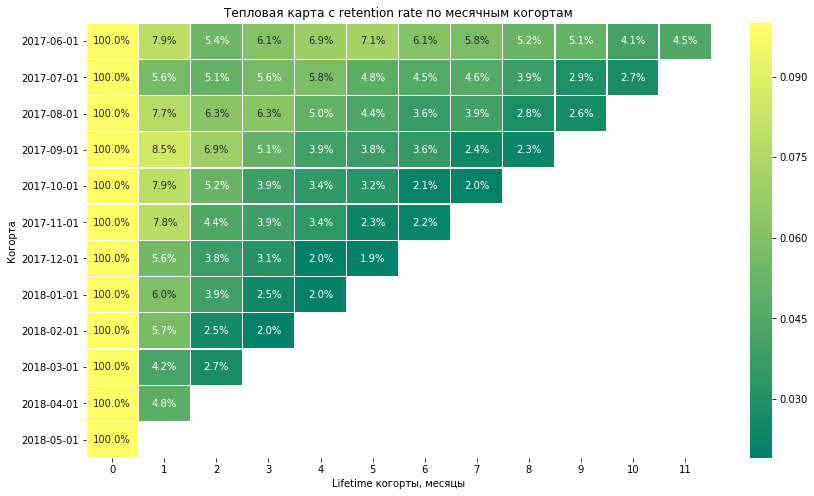

In [88]:
# Тепловая карта с retention rate по месячным когортам

plt.figure(figsize=(14, 8))
sns.heatmap(visits_retention, annot=True, fmt='.1%', 
                vmax=0.1, linewidths=0.3, cmap = 'summer', 
                yticklabels = visits_retention.index.date)
plt.title('Тепловая карта с retention rate по месячным когортам')
plt.xlabel('Lifetime когорты, месяцы')
plt.ylabel('Когорта')
plt.show()

<a id='step2.1.4'></a>
### Вывод

<span style="color:#2B8E6A">**DAU / WAU / MAU**</span>  
Среднее количество пользователей в день: **DAU = 921** пользователей,  
Среднее количество пользователей в неделю: **WAU = 5 740** пользователей,  
Среднее количество пользователей в год: **MAU = 24 240** пользователей.
   
Рост посещаемости можно отметить в осенне-зимний сезон, а также в начале недели и в воскресенье.  
Снижение посещаемости можно отметить в летний период, а также к концу недели.  

За год был один всплеск и один спад в посещениях: в "Черную пятницу" (24 ноября 2017 года) и 31 марта 2018 года соответственно. Необходимо проверить, что могло повлиять на посещения в эти даты.
   
В разбивке по устройствам использования лидируют десктопные устройства (262 567 пользователей против 96 833 пользователей мобильных устройств).
   
<span style="color:#2B8E6A">**Sticky Factor**</span>    
Регулярность использования приложения в течение недели - **16%**,  
Регулярность использования приложения в течение месяца - **3,8%**. 

Тип устройства не влияет на данный показатель.
     
Месячный sticky factor близок к своему минимальному значению, есть вероятность что пользователи не задерживаются в приложении и retention достаточно низкий. Проверим гипотезу при расчете retention.
      
<span style="color:#2B8E6A">**Пользовательские сессии**</span>  
Пользователи **в день** на сайт заходят в среднем **1 раз**, вне зависимости от типа устройства.   
Средняя продолжительность сессии - **5 минут**.  
Самая часто встречающаяся длительность сессии - **1 минута**.  
Cредняя продолжительность сессии с десктопных устройств - 6 минут, в то время как средняя продолжительность сессии с мобильных устройств в 2 раза меньше и составляет 3 минуты.

<span style="color:#2B8E6A">**Retention Rate**</span>  
В целом, помесячный Retention Rate достаточно невысокий (в лучшие периоды не превышает 9%), однако учитывая специфику сервиса (продажа билетов), сложно ожидать более высоких показателей, т.к. мало кто посещает мероприятия ежемесячно.

Самый высокий Retention Rate первого месяца был у сентябрьской когорты (**8,5%**). Начиная с октябрьской когорты, Retention Rate первого месяца стал стабильно снижаться, в то время как именно с октябрьской когорты сильно увеличилось количество новых пользователей (c 17 000 в сентябре до 26 000 в октябре).  

Есть вероятность, что стратегия привлечения новых пользователей в осенне - зимний период сработала, а вот над стратегией удержания пользователей необходимо поработать.   

В итоге, можно отметить, что весной 2018 года наблюдается стабильный спад как в количестве новых пользователей, так и снижение показателей удержания старых пользователей.
    

<a id='step2.2'></a>
### Исследование продаж

<a id='step2.2.1'></a>
###  Когда люди начинают покупать?

In [89]:
# Таблица с заказами
orders.head()

,order_date,revenue,user_id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [90]:
# Расчет даты первого заказа пользователя
first_order_date = orders.groupby(['user_id'])['order_date'].min().dt.date

In [91]:
# Переименование series для дальнешего объединения 
first_order_date.name = 'first_order_date'

In [92]:
# Превратим first_order_date в DataFrame
first_order_date = first_order_date.reset_index()

In [93]:
# Превратим first_activity_date в DataFrame
first_activity_date = first_activity_date.reset_index()

In [94]:
# Объединение first_activity_date с first_order_date
users_first_actions = first_activity_date.merge(first_order_date, how = 'left', on = 'user_id')

In [95]:
users_first_actions.head()

,user_id,first_activity_date,first_order_date
0,11863502262781,2018-03-01,NaN
1,49537067089222,2018-02-06,NaN
2,297729379853735,2017-06-07,NaN
3,313578113262317,2017-09-18,2018-01-03
4,325320750514679,2017-09-30,NaN


In [96]:
# Расчет количества пользователей, посещавших сайт, но не совершавших покупки
users_first_actions['first_order_date'].isnull().sum()

191646

In [97]:
# Доля несовершавших покупки от общего числа пользователей
users_first_actions['first_order_date'].isnull().sum() / len(users_first_actions)

0.8399300518475341

In [98]:
# Расчет длительности до первой покупки
users_first_actions['first_order_lag'] = users_first_actions['first_order_date'] - users_first_actions['first_activity_date']

In [99]:
# Приведение значений в столбце first_order_lag к целочисленному типу данных
users_first_actions['first_order_lag'] = (users_first_actions['first_order_lag'] / np.timedelta64(1,'D')).astype('Int64')

In [100]:
# Проверка
users_first_actions[~users_first_actions['first_order_date'].isnull()].head()

,user_id,first_activity_date,first_order_date,first_order_lag
3,313578113262317,2017-09-18,2018-01-03,107
22,1575281904278712,2017-06-03,2017-06-03,0
35,2429014661409475,2017-10-11,2017-10-11,0
36,2464366381792757,2018-01-27,2018-01-28,1
38,2551852515556206,2017-11-24,2017-11-24,0


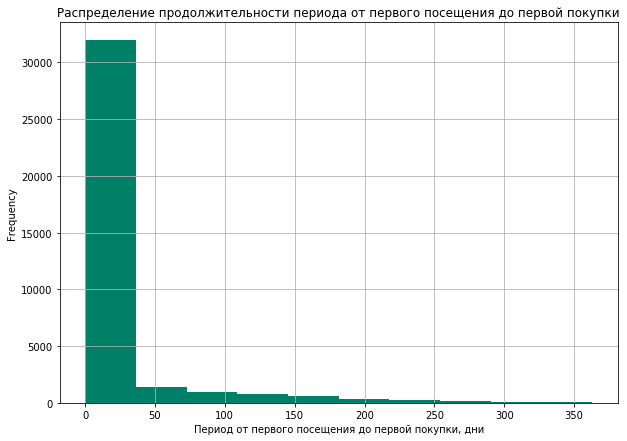

In [101]:
# Распределение продолжительности периода от первого посещения до первой покупки
users_first_actions[~users_first_actions['first_order_date'].isnull()]['first_order_lag'].plot(kind = 'hist',
                                                                                               figsize = (10, 7),
                                                                                               grid = True,
                                                                                               colormap ='summer')

plt.title('Распределение продолжительности периода от первого посещения до первой покупки')
plt.xlabel('Период от первого посещения до первой покупки, дни')
plt.show()

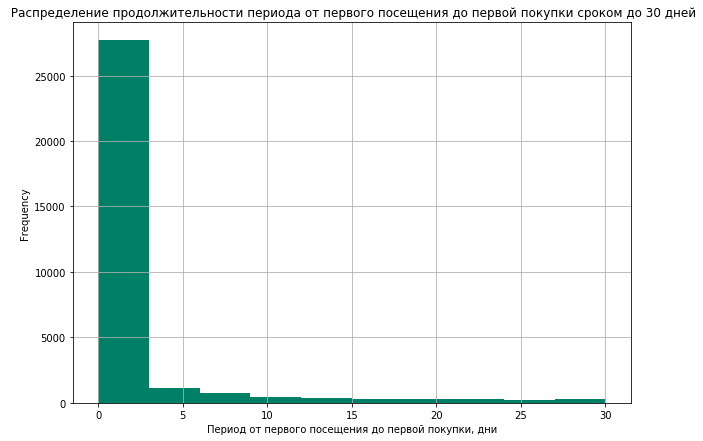

In [102]:
# Распределение продолжительности периода от первого посещения до первой покупки сроком до 30 дней
users_first_actions[~users_first_actions['first_order_date'].isnull()]['first_order_lag'].plot(kind = 'hist',
                                                                                               figsize = (10, 7),
                                                                                               grid = True,
                                                                                               colormap ='summer',
                                                                                               range = (0, 30))

plt.title(' Распределение продолжительности периода от первого посещения до первой покупки сроком до 30 дней')
plt.xlabel('Период от первого посещения до первой покупки, дни')
plt.show()

In [103]:
# Доля совершивших покупки в первое посещение из числа пользователей, совершивших покупку 
len(users_first_actions[users_first_actions['first_order_lag'] == 0]) / len(users_first_actions[~users_first_actions['first_order_date'].isnull()])

0.6855679982476796

In [104]:
# Доля совершивших покупки в течение 30 дней после первого посещения из числа пользователей, совершивших покупку 
len(users_first_actions[users_first_actions['first_order_lag'] < 30]) / len(users_first_actions[~users_first_actions['first_order_date'].isnull()])

0.8633190044629412

Как видно на графиках, большая часть покупок совершается в первое посещение (около 70% из числа пользователей, совершивших покупки за изучаемый период) и почти 86% совершают покупку в течение 30 дней после первого посещения (из числа совершивших покупки за изучаемый период). 
Кажется, что это достаточно неплохие показатели.  
Однако есть выбросы, максимальный сроком около года (возможно есть и более длительный период, но в анализе используются данные за год).

In [105]:
# Расчет медианной продолжительности периода от первого посещения до первой покупки
users_first_actions[~users_first_actions['first_order_date'].isnull()]['first_order_lag'].median()

0.0

<a id='step2.2.2'></a>
### Сколько раз покупают за период?

In [106]:
# Выделение даты, года, месяца, недели в отдельные столбцы
orders['order_day'] = orders['order_date'].dt.date
orders['order_year'] = orders['order_date'].dt.year
orders['order_month'] = orders['order_date'].astype('datetime64[M]')
orders['order_week'] = orders['order_date'].dt.week

In [107]:
# Проверка
orders.sample(5)

,order_date,revenue,user_id,order_day,order_year,order_month,order_week
14778,2017-10-26 22:11:00,3.30,8056418121947262981,2017-10-26,2017,2017-10-01,43
23951,2017-12-14 01:16:00,1.50,9926814115594395204,2017-12-14,2017,2017-12-01,50
3140,2017-07-12 15:10:00,1.22,9103340429210011711,2017-07-12,2017,2017-07-01,28
9854,2017-09-30 16:56:00,0.37,16357550782433948500,2017-09-30,2017,2017-09-01,39
479,2017-06-05 22:22:00,0.61,13347953361295103381,2017-06-05,2017,2017-06-01,23


#### Покупки в день

In [108]:
# Расчет количества совершаемых покупок в день и количество пользователей, совершивших покупку
daily_orders = orders.groupby('order_day').agg({'user_id':['count', 'nunique']})

In [109]:
daily_orders.columns = ['total_orders', 'total_users']

In [110]:
# Расчет количества покупок на пользователя в день
daily_orders['orders_per_user'] = daily_orders['total_orders'] / daily_orders['total_users']

In [111]:
daily_orders.head()

,total_orders,total_users,orders_per_user
order_day,,,
2017-06-01,96,86,1.116279
2017-06-02,111,101,1.099010
2017-06-03,67,61,1.098361
2017-06-04,66,59,1.118644
2017-06-05,161,146,1.102740


In [112]:
# Среднее количество покупок в день
daily_orders['total_orders'].median()

136.0

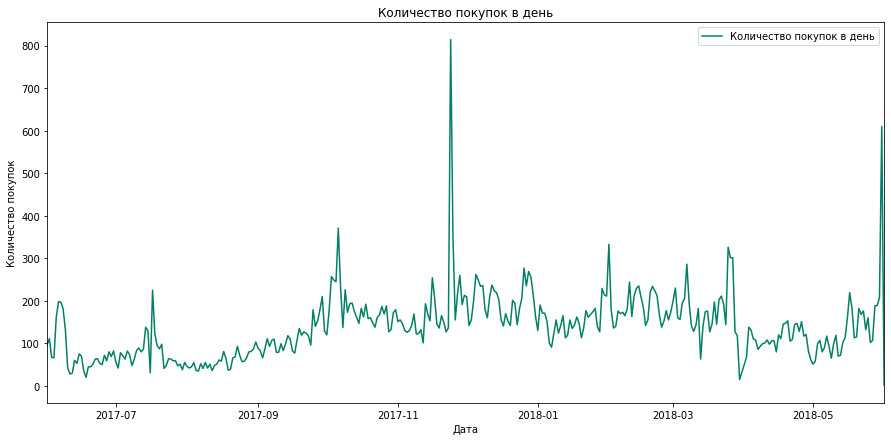

In [113]:
# График распределения количества покупок в день
daily_orders['total_orders'].plot(figsize =(15, 7), colormap='summer')

plt.title('Количество покупок в день')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.legend(['Количество покупок в день'])
plt.show()

График распределения покупок в день аналогичен графику распределения посещений сайта в день (с аналогичными спадами и подъемами).

In [114]:
# Среднее количество покупок в день на пользователя
daily_orders['orders_per_user'].median()

1.0778499278499278

#### Покупки в неделю

In [115]:
# Расчет количества совершаемых покупок в неделю и количество пользователей, совершивших покупку
weekly_orders = orders.groupby(['order_year', 'order_week']).agg({'user_id':['count', 'nunique']})

In [116]:
weekly_orders.columns = ['total_orders', 'total_users']

In [117]:
# Расчет количества покупок на пользователя в день
weekly_orders['orders_per_user'] = weekly_orders['total_orders'] / weekly_orders['total_users']

In [118]:
weekly_orders.head()

total_orders  total_users  orders_per_user
order_year order_week                                            
2017       22                   340          295         1.152542
           23                   938          821         1.142509
           24                   343          317         1.082019
           25                   371          339         1.094395
           26                   460          411         1.119221

In [119]:
# Среднее количество покупок в неделю
weekly_orders['total_orders'].median()

991.0

In [120]:
# Среднее количество покупок в неделю на пользователя
weekly_orders['orders_per_user'].median()

1.1574803149606299

#### Покупки в месяц

In [121]:
# Расчет количества совершаемых покупок в месяц и количество пользователей, совершивших покупку
monthly_orders = orders.groupby('order_month').agg({'user_id':['count', 'nunique']})

In [122]:
monthly_orders.columns = ['total_orders', 'total_users']

In [123]:
monthly_orders['orders_per_user'] = monthly_orders['total_orders'] / monthly_orders['total_users']

In [124]:
# Среднее количество покупок в месяц
monthly_orders['total_orders'].median()

4346.0

In [125]:
# Среднее количество покупок в месяц на пользователя
monthly_orders['orders_per_user'].median()

1.2262979683972912

#### Покупки в год на пользователя

In [126]:
# Данные о покупках по годам
year_orders = orders.groupby('order_year').agg({'user_id':['count', 'nunique']})
year_orders.columns = ['total_orders', 'total_users']
year_orders['orders_per_user'] = year_orders['total_orders'] / year_orders['total_users']

In [127]:
# Количество покупок в год на пользователя
year_orders[['orders_per_user']]

,orders_per_user
order_year,
2017,1.326844
2018,1.315222


<a id='step2.2.3'></a>
### Какой средний чек?

In [128]:
# Таблица с заказами
orders.head()

,order_date,revenue,user_id,order_day,order_year,order_month,order_week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017,2017-06-01,22
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017,2017-06-01,22
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017,2017-06-01,22
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017,2017-06-01,22
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017,2017-06-01,22


In [129]:
# Разброс выручки с заказов
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [130]:
# Расчет среднего чека за весь рассматриваемый период
orders['revenue'].mean()   

4.999646930477041

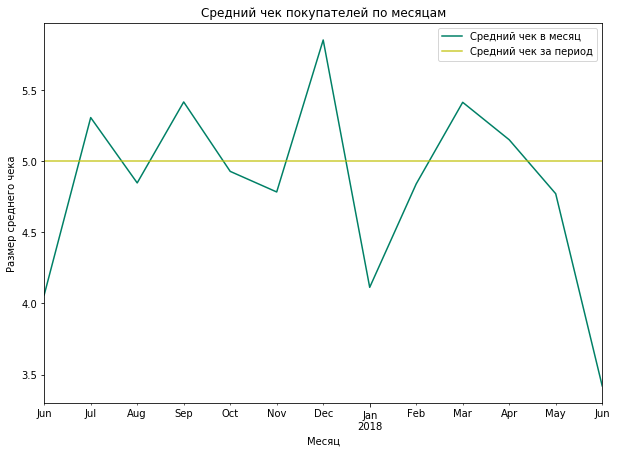

In [131]:
# Месячная динамика среднего чека
(orders.groupby('order_month')['revenue'].mean()).plot(figsize =(10, 7),
                                                         colormap='summer') 

plt.axhline(orders['revenue'].mean(), color = 'y', alpha = 0.8)


plt.title('Средний чек покупателей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Размер среднего чека')
plt.legend(['Средний чек в месяц', 'Cредний чек за период'])
plt.show()

In [132]:
orders.groupby('order_month')['revenue'].mean()

order_month
2017-06-01    4.060106
2017-07-01    5.306589
2017-08-01    4.847139
2017-09-01    5.416448
2017-10-01    4.928280
2017-11-01    4.783518
2017-12-01    5.852139
2018-01-01    4.112927
2018-02-01    4.840095
2018-03-01    5.413930
2018-04-01    5.150645
2018-05-01    4.771279
2018-06-01    3.420000
Name: revenue, dtype: float64

In [133]:
# Проверка заказов за июнь 2018 года (дата выбивается из исследуемого периода)
orders[orders['order_day'] == DT.date(2018, 6, 1)]

,order_date,revenue,user_id,order_day,order_year,order_month,order_week
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01,2018,2018-06-01,22


За июнь 2018 года имеются данные только по одному заказу, соответственно, не будем принимать их во внимание при исследовании средних значений чека.  


Т.к. среди данных о выручке есть большое количество выбросов, рассчитаем медианный чек и посмотрим его распределение для понимания, сколько в среднем пользователи тратят денег без учета выбросов.

<a id='step2.2.3'></a>
#### Медианный чек

In [134]:
# Расчет медианного чека за весь рассматриваемый период
orders['revenue'].median() 

2.5

In [135]:
# Годовая динамика медианного чека
orders.groupby('order_year')['revenue'].median()

order_year
2017    2.57
2018    2.44
Name: revenue, dtype: float64

Большой разницы в медианном чеке за 2017 и 2018 год не наблюдается.

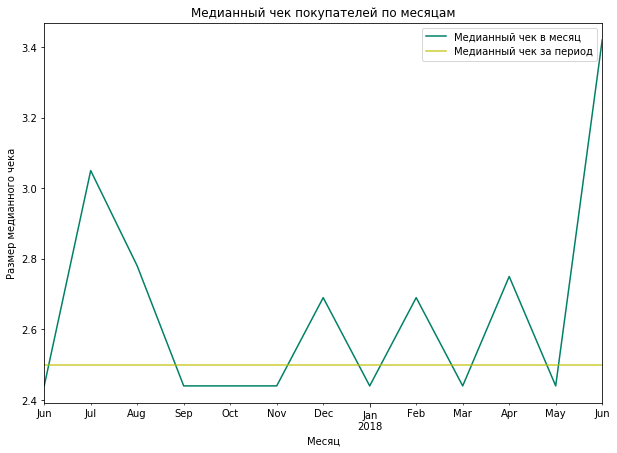

In [136]:
# Месячная динамика медианного чека
(orders.groupby('order_month')['revenue'].median()).plot(figsize =(10, 7),
                                                         colormap='summer') 

plt.axhline(orders['revenue'].median(), color = 'y', alpha = 0.8)


plt.title('Медианный чек покупателей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Размер медианного чека')
plt.legend(['Медианный чек в месяц', 'Медианный чек за период'])
plt.show()

Т.к. за июнь 2018 года имеются данные только по одному заказу, не будем принимать их во внимание.  
Таким образом, самый большой средний чек наблюдается в июле (возможно, влияние оказывают летние фестивали).  
Осенью размер среднего чека падает: его размер во все осенние месяцы ниже, чем размер среднего чека в целом за год.  
Размер среднего чека ниже остальных в месяцы с праздничными днями - Январь, Март, Май (возможно, в праздничные дни люди больше посещают недорогостоящие события, типа кинотеатров, выставок и т.д., а в остальные месяцы больше влияние на средний чек оказывают более дорогие события, типа спектаклей, концертов и т.д.)

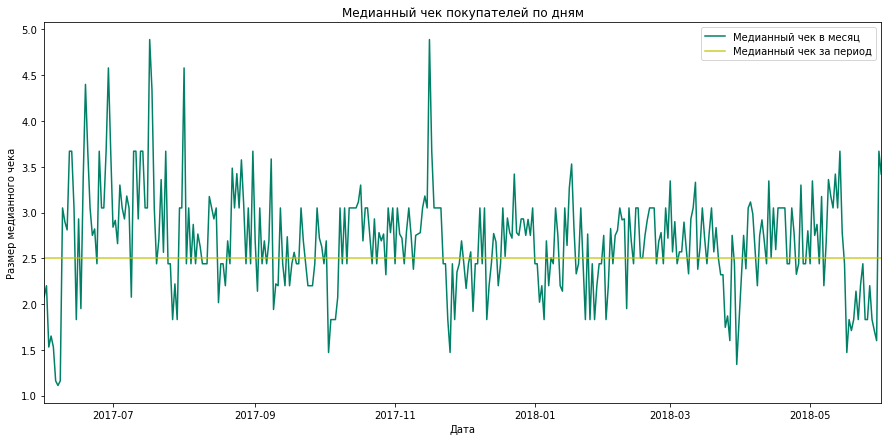

In [137]:
# Дневная динамика среднего чека
(orders.groupby('order_day')['revenue'].median()).plot(figsize =(15, 7),
                                                         colormap='summer') 

plt.axhline(orders['revenue'].median(), color = 'y', alpha = 0.8)


plt.title('Медианный чек покупателей по дням')
plt.xlabel('Дата')
plt.ylabel('Размер медианного чека')
plt.legend(['Медианный чек в месяц', 'Медианный чек за период'])
plt.show()

На графике можно заметить всплеск в осенний период в конце ноября. Есть вероятность, что влияние оказали акции, проводимые в "Черную пятницу", однако сразу после этого всплеска идет сильный спад. Возможно, большая часть пользователей приобрели интересующие их дорогостоящие билеты во время акций, после чего интерес к дорогим билетам снизился.

<a id='step2.2.4'></a>
### Сколько денег приносят? (LTV)

In [138]:
# Общая сумма выручки за рассматриваемый период
orders['revenue'].sum()

252057.19999999998

При расчете LPV примем валовую маржинальность магазина за 100%, соответственно LPV будет рассчитываться на основе выручки (revenue).

In [139]:
# Расчет даты первой покупки пользователя
first_users_orders = (orders.groupby('user_id')['order_month'].min()).reset_index()

In [140]:
# Перименование столбцов для объединения таблиц
first_users_orders.columns = ['user_id', 'first_order_month']

In [141]:
first_users_orders.head()

,user_id,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [142]:
# Объединение с таблицей orders
orders = orders.merge(first_users_orders, on = 'user_id')

In [143]:
orders.sample(5)

,order_date,revenue,user_id,order_day,order_year,order_month,order_week,first_order_month
35657,2018-02-01 12:58:00,1.59,11471852190111683953,2018-02-01,2018,2018-02-01,5,2018-02-01
15418,2017-10-08 23:32:00,7.33,6255246222381492616,2017-10-08,2017,2017-10-01,40,2017-10-01
9749,2018-05-16 22:57:00,1.95,3560684527150572995,2018-05-16,2018,2018-05-01,20,2017-09-01
31941,2018-01-05 16:35:00,3.67,2601219150432953369,2018-01-05,2018,2018-01-01,1,2018-01-01
18029,2017-10-24 10:58:00,3.67,12978113615613517883,2017-10-24,2017,2017-10-01,43,2017-10-01


In [144]:
# Расчет lifetime для каждой покупки
orders['cohort_lifetime'] = (orders['order_month'] - orders['first_order_month'])/np.timedelta64(1,'M')

In [145]:
# Приведение lifetime к целочисленному типу
orders['cohort_lifetime'] = round(orders['cohort_lifetime']).astype('int') 

In [146]:
# Расчет суммарной выручки по first_order_month и cohort_lifetime
orders_cohorts = orders.groupby(['first_order_month','cohort_lifetime']).agg({'revenue': 'sum'}).reset_index()

In [147]:
orders_cohorts.head()

,first_order_month,cohort_lifetime,revenue
0,2017-06-01,0,9557.49
1,2017-06-01,1,981.82
2,2017-06-01,2,885.34
3,2017-06-01,3,1931.30
4,2017-06-01,4,2068.58


In [148]:
# Количество новых покупателей по месяцам
total_buyers = first_users_orders.groupby('first_order_month').agg({'user_id': 'nunique'}).reset_index()

In [149]:
# Перименование столбцов для объединения таблиц
total_buyers.columns = ['first_order_month', 'total_buyers'] 

In [150]:
total_buyers.head()

,first_order_month,total_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [151]:
# Объединение с таблицей orders_cohorts
orders_cohorts = orders_cohorts.merge(total_buyers, on = 'first_order_month')

In [152]:
# Расчет LTV по когортам
orders_cohorts['ltv'] = orders_cohorts['revenue'] / orders_cohorts['total_buyers']

In [153]:
orders_cohorts.head()

,first_order_month,cohort_lifetime,revenue,total_buyers,ltv
0,2017-06-01,0,9557.49,2023,4.724414
1,2017-06-01,1,981.82,2023,0.485329
2,2017-06-01,2,885.34,2023,0.437637
3,2017-06-01,3,1931.30,2023,0.954671
4,2017-06-01,4,2068.58,2023,1.022531


In [154]:
ltv_pivot = orders_cohorts.pivot(index = 'first_order_month',
                                columns = 'cohort_lifetime',
                                values = 'ltv').cumsum(axis = 1)

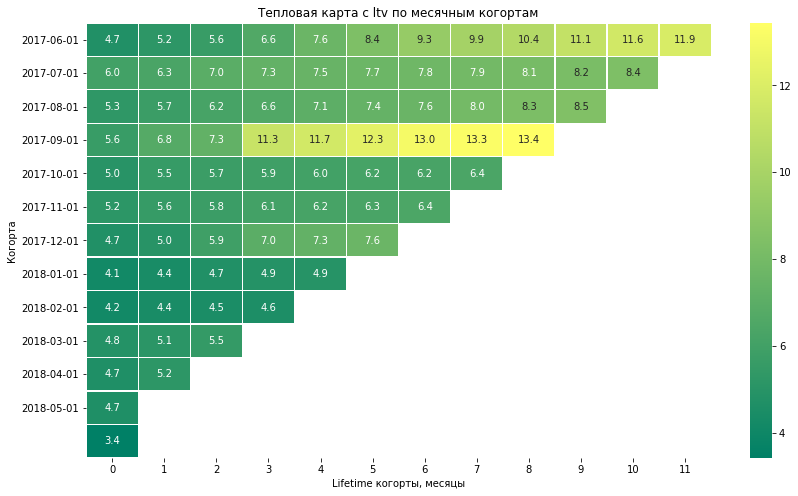

In [155]:
# Тепловая карта с ltv по месячным когортам

plt.figure(figsize = (14, 8))
sns.heatmap(ltv_pivot, annot = True, fmt = '.1f',
            linewidths = 0.3, cmap = 'summer', 
            yticklabels = visits_retention.index.date)
plt.title('Тепловая карта с ltv по месячным когортам')
plt.xlabel('Lifetime когорты, месяцы')
plt.ylabel('Когорта')
plt.show()

Расчитаем средний LTV за 6 месяцев

средний LTV за 6 месяцев

1. Когорты, прожившие 6 месяцев
2. Первые 6 месяцев жизни когорт
3. Средний LTV

In [156]:
# Срез по когортам, прожившим более 6 месяцев
orders_cohorts_slice = orders_cohorts[orders_cohorts['first_order_month'] <= '2017-12-01']

In [157]:
# Срез данных за первые 6 месяцев жизни когорт
orders_cohorts_slice = orders_cohorts_slice[orders_cohorts_slice['cohort_lifetime'] <= 5]

In [158]:
# Средний ltv за каждый месяц жизни когорты
orders_cohorts_slice.pivot(index = 'first_order_month',
                                columns = 'cohort_lifetime',
                                values = 'ltv').cumsum(axis = 1).mean(axis = 0)

cohort_lifetime
0    5.221755
1    5.736825
2    6.216343
3    7.248927
4    7.635561
5    7.969053
dtype: float64

<a id='step2.2.5'></a>
### Вывод

<span style="color:#2B8E6A">**Совершение покупок**</span>    
Почти 84% посещающих сайт уникальных пользователей ни разу за исследуемый период не совершали покупки.  
Необходимо разобраться, почему такой большой процент пользователей не совершают покупки (что им мешает? с какой целью они заходят на сайт?).   

Среди пользователей, совершивших покупку в изучаемый период:  
* около 70% совершили покупку в первое посещение
* около 86% совершают покупку в течение 30 дней после первого посещения. 
Кажется, что это достаточно неплохие показатели. 

В среднем пользователи совершают:
* 136 покупок в день,
* 991 покупку в неделю,
* 4346 покупок в месяц.

За изученный период каждый пользователь в среднем совершил одну покупку.

<span style="color:#2B8E6A">**Средний чек**</span>  
Общая сумма выручки за рассматриваемый период составляет **252057.2 у.е**.  
В данных о выручке имеется большое количество выбросов.  
Средний чек составляет почти 5 у.е.
Самый большой средний чек зафиксирован в декабре, после чего, в январе наблюдается спад - один из самых низких средних чеков за исследуемый период. Самый низкий средний чек был в июне 2017 года.

<span style="color:#2B8E6A">**Медианный чек**</span>    
Размер среднего чека за весь рассматриваемый период составляет **2.5 у.е**.  
Самый высокий средний чек наблюдался в июле и составлял **3.05 y.e**.  
Самый низкий средний чек наблюдался в осенние месяцы, а также в месяцы праздников (Январь, Март, Май).  


<span style="color:#2B8E6A">**LTV**</span>   
Больше всего денег клиенты приносит в первый месяц совершения покупки на сайте.  
Начиная с сентябрьской когорты, LTV первого месяца начал стабильно снижаться для последующих когорт, и обратно расти стал начиная с февральской когорты.  
Также можно отметить, что сентябрьская когорта показала себя наиболее прибыльной: несмотря на то, что время жизни когорты в текущем анализе всего 8 месяцев, суммарный LTV когорты больше, чем у трех предыдущих когорт с более продолжительным временем жизни, и составляет 13.5 y.e. На это мог повлиять необычный всплеск LTV на третьем месяце жизни когорты (необходимо понять, что заставило пользователей сентябрьской когорты покупать в декабре - возможно, для них проводились какие-то акции при совершении первой покупки).



<a id='step2.3'></a>
### Исследование маркетинга

<a id='step2.3.1'></a>
### Сколько денег потратили?

In [159]:
# Таблица с расходами
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


#### Всего

In [160]:
# Общие расходы за исследуемый период
costs['costs'].sum()

329131.62

#### На каждый источник

In [161]:
# Расходы на каждый источник привлечения за исследуемый период
costs_per_source = costs.groupby('source_id')['costs'].sum()

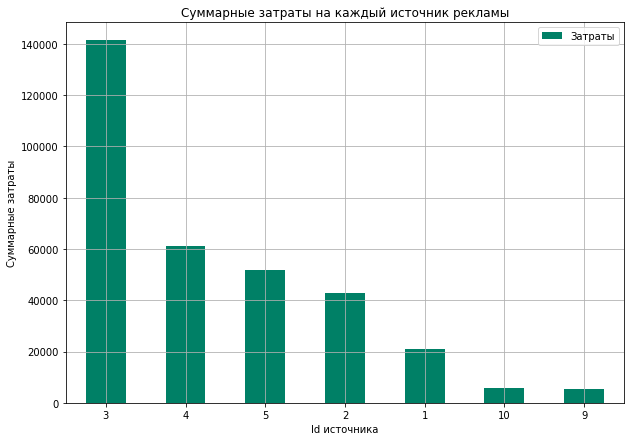

In [162]:
costs_per_source.sort_values(ascending = False).plot(kind = 'bar',
                                                     figsize =(10, 7),
                                                     grid = True,
                                                     colormap='summer')

plt.title('Суммарные затраты на каждый источник рекламы')
plt.xlabel('Id источника')
plt.xticks(rotation=0)
plt.ylabel('Суммарные затраты')
plt.legend(['Затраты'])
plt.show()

#### По времени

In [163]:
# Выделение месяца в отдельный столбец
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

In [164]:
costs.sample(5)

,source_id,dt,costs,costs_month
559,2,2017-12-14,213.38,2017-12-01
153,1,2017-11-01,69.03,2017-11-01
2136,9,2018-04-19,11.20,2018-04-01
895,3,2017-11-17,248.10,2017-11-01
415,2,2017-07-23,41.43,2017-07-01


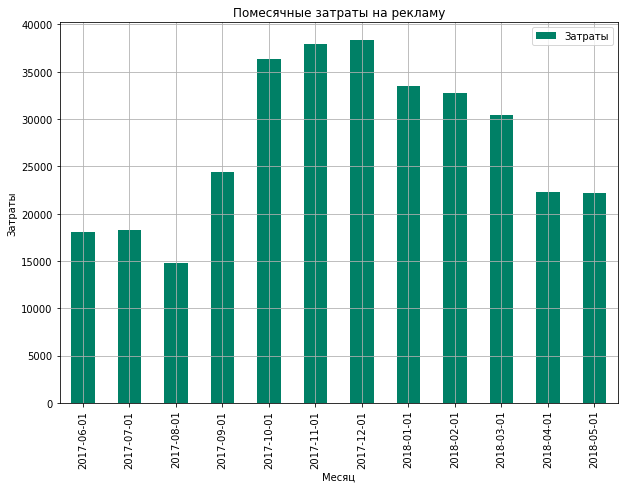

In [165]:
ax = costs.groupby('costs_month')['costs'].sum().plot(kind = 'bar',
                                                 figsize =(10, 7),
                                                 grid = True,
                                                 colormap='summer')

ax.set_xticklabels(costs.groupby('costs_month')['costs'].sum().index.date)
plt.title('Помесячные затраты на рекламу')
plt.xlabel('Месяц')
plt.ylabel('Затраты')
plt.legend(['Затраты'])
plt.show()


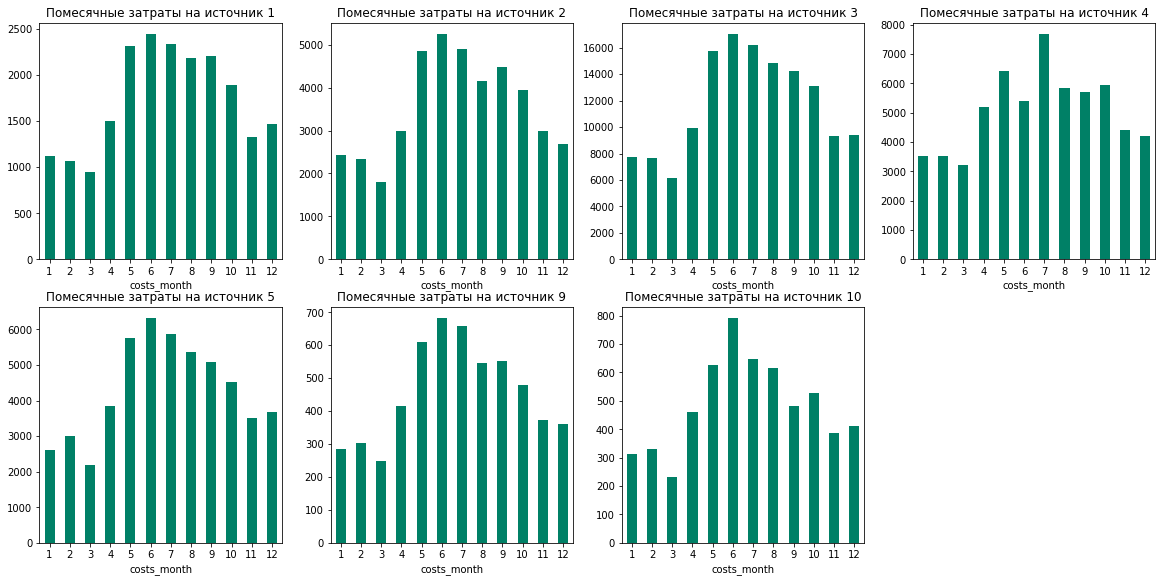

In [166]:
# Помесячные затраты для каждого источника
fig = plt.figure(figsize=(20, 20))

ax_1 = fig.add_subplot(4, 4, 1)
ax_2 = fig.add_subplot(4, 4, 2)
ax_3 = fig.add_subplot(4, 4, 3)
ax_4 = fig.add_subplot(4, 4, 4)
ax_5 = fig.add_subplot(4, 4, 5)
ax_6 = fig.add_subplot(4, 4, 6)
ax_7 = fig.add_subplot(4, 4, 7)

temp = [ax_1, ax_2, ax_3, ax_4, ax_5, ax_6, ax_7]
xlabels =[i for i in range(1, 13)]
j = 0 

for i in costs['source_id'].unique():
    costs.query('source_id == @i').groupby('costs_month')['costs'].sum().plot(kind = 'bar', 
                                                                         colormap = 'summer',
                                                                         ax = temp[j])
    temp[j].set_title('Помесячные затраты на источник {}'.format(i))
    temp[j].set_xticklabels(xlabels, rotation = 0)
    j += 1
    
plt.show()

<a id='step2.3.2'></a>
### Сколько стоило привлечение одного покупателя из каждого источника?

In [167]:
# Определение для каждого пользователя источника привлечения
first_user_source = visits.sort_values(by = 'session_start').groupby('user_id').agg({'source_id' : 'first'}).reset_index()

In [168]:
# Добавление в таблицу с заказами источник привлечения
orders = orders.merge(first_user_source, on = 'user_id')

In [169]:
orders.head()

,order_date,revenue,user_id,order_day,order_year,order_month,order_week,first_order_month,cohort_lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017,2017-06-01,22,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017,2017-06-01,22,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017,2017-06-01,22,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017,2017-06-01,22,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017,2017-06-01,22,2017-06-01,0,3


In [170]:
# Количество покупателей из каждого источника в разбивке по месяцам
total_buyers_per_source = (orders.groupby(['first_order_month', 'source_id'])['user_id'].nunique().reset_index())

In [171]:
total_buyers_per_source.head()

,first_order_month,source_id,user_id
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [172]:
# Помесячные затраты на рекламу в разбивке по источникам
costs_per_month = costs.groupby(['costs_month', 'source_id'])['costs'].sum()

In [173]:
# Приведение к df 
costs_per_month = costs_per_month.reset_index()

In [174]:
costs_per_month.head()

,costs_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [175]:
# Объединение таблиц total_buyers_per_source и costs_per_month
cac_per_source = total_buyers_per_source.merge(costs_per_month, 
                                               left_on = ['first_order_month', 'source_id'],
                                               right_on = ['costs_month', 'source_id'],
                                               how = 'outer')

In [176]:
# Проверка наличия пустых значений
cac_per_source.isnull().sum()

first_order_month    0
source_id            0
user_id              0
costs_month          2
costs                2
dtype: int64

In [177]:
# Строки с пустыми значениями
cac_per_source[(cac_per_source['costs_month'].isnull())&(cac_per_source['costs'].isnull())]

,first_order_month,source_id,user_id,costs_month,costs
19,2017-08-01,7,1,NaT,NaN
85,2018-06-01,4,1,NaT,NaN


Т.к. за июль 2018 год у нас нет данных о затратах, то данную строку можно удалить.  
В августе на 7ой источник денег потрачено не было, поэтому проставим 0 в соответствующую ячейку.

In [178]:
# Удаление данных за июль 2018 года
cac_per_source = cac_per_source.drop(85) 

In [179]:
# Замена пустого значения на 0 
cac_per_source['costs'] = cac_per_source['costs'].fillna(0)

In [180]:
# Расчет CAC для каждого месяца и источника
cac_per_source['costs_per_user'] = cac_per_source['costs'] / cac_per_source['user_id']

In [181]:
cac_per_source.head()

,first_order_month,source_id,user_id,costs_month,costs,costs_per_user
0,2017-06-01,1,190,2017-06-01,1125.61,5.924263
1,2017-06-01,2,235,2017-06-01,2427.38,10.329277
2,2017-06-01,3,638,2017-06-01,7731.65,12.118574
3,2017-06-01,4,413,2017-06-01,3514.80,8.510412
4,2017-06-01,5,384,2017-06-01,2616.12,6.812813


In [182]:
# Сводная таблица со стоимостью привлечения клиентов с разбивкой по месяцам и источникам
cac_per_source_pivot = cac_per_source.pivot(index = 'first_order_month', columns = 'source_id', values = 'costs_per_user')

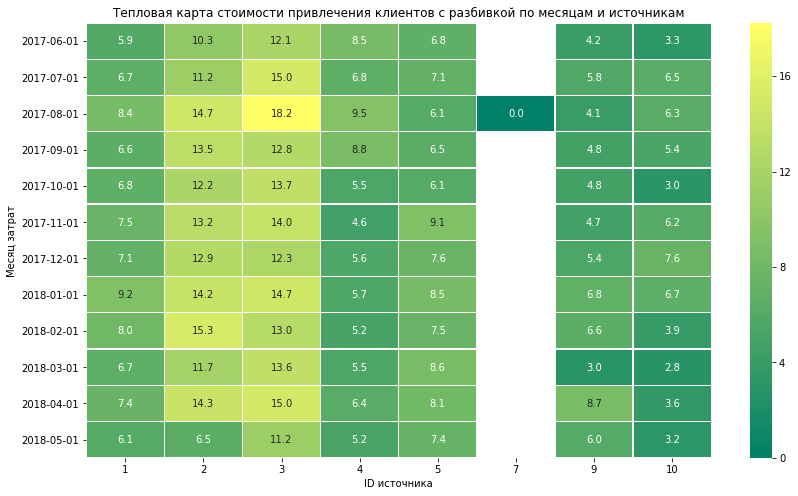

In [183]:
# Тепловая карта стоимости привлечения клиентов с разбивкой по месяцам и источникам

plt.figure(figsize=(14, 8))
sns.heatmap(cac_per_source_pivot, annot=True, fmt='.1f', 
            linewidths=0.3, cmap = 'summer', 
            yticklabels = cac_per_source_pivot.index.date)
plt.title('Тепловая карта стоимости привлечения клиентов с разбивкой по месяцам и источникам')
plt.xlabel('ID источника')
plt.ylabel('Месяц затрат')
plt.show()

In [184]:
cac_per_source.head()

,first_order_month,source_id,user_id,costs_month,costs,costs_per_user
0,2017-06-01,1,190,2017-06-01,1125.61,5.924263
1,2017-06-01,2,235,2017-06-01,2427.38,10.329277
2,2017-06-01,3,638,2017-06-01,7731.65,12.118574
3,2017-06-01,4,413,2017-06-01,3514.80,8.510412
4,2017-06-01,5,384,2017-06-01,2616.12,6.812813


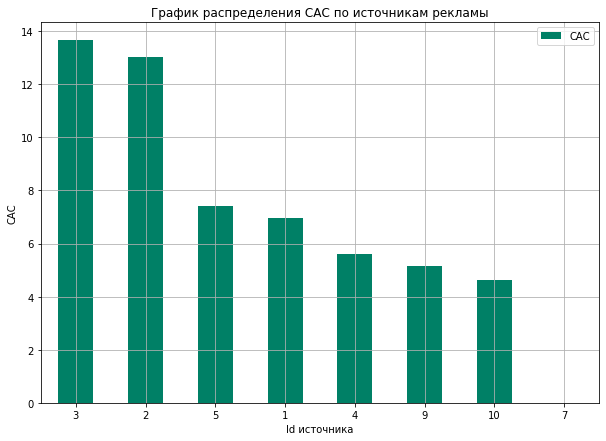

In [185]:
# График распределения CAC по источникам рекламы
cac_per_source.groupby('source_id')['costs_per_user'].median().sort_values(ascending = False).plot(kind = 'bar',
                                                                                                x = 'source_id',
                                                                                                y = 'costs_per_user',
                                                                                                figsize =(10, 7),
                                                                                                grid = True,
                                                                                                colormap='summer')

plt.title('График распределения CAC по источникам рекламы')
plt.xlabel('Id источника')
plt.xticks(rotation = 0)
plt.ylabel('CAC')
plt.legend(['CAC'])
plt.show()

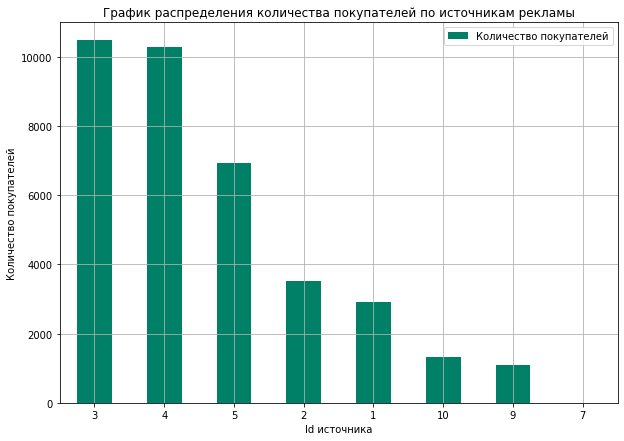

In [186]:
#График распределения количества покупателей по источникам рекламы
cac_per_source.groupby('source_id')['user_id'].sum().sort_values(ascending = False).plot(kind = 'bar',
                                                                                         x = 'source_id',
                                                                                         y = 'user_id',
                                                                                         figsize =(10, 7),
                                                                                         grid = True,
                                                                                         colormap='summer')

plt.title('График распределения количества покупателей по источникам рекламы')
plt.xlabel('Id источника')
plt.xticks(rotation = 0)
plt.ylabel('Количество покупателей')
plt.legend(['Количество покупателей'])
plt.show()

<a id='step2.3.3'></a>
### Насколько окупились расходы? (ROI)

In [187]:
# Таблица с заказами 
orders.head()

,order_date,revenue,user_id,order_day,order_year,order_month,order_week,first_order_month,cohort_lifetime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017,2017-06-01,22,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017,2017-06-01,22,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017,2017-06-01,22,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017,2017-06-01,22,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017,2017-06-01,22,2017-06-01,0,3


In [188]:
# Просмотр информации о заказе за июнь 2018 года
orders[orders['order_month'] == '2018-06-01']

,order_date,revenue,user_id,order_day,order_year,order_month,order_week,first_order_month,cohort_lifetime,source_id
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01,2018,2018-06-01,22,2018-06-01,0,4


In [189]:
# Удлаение информации о заказе за июнь 2018 года
orders = orders.drop(50414)

In [190]:
# Расчет суммарной выручки по first_order_month, cohort_lifetime и source_id
orders_cohorts_per_source = orders.groupby(['first_order_month','cohort_lifetime', 'source_id']).agg({'revenue': 'sum'}).reset_index()

In [191]:
orders_cohorts_per_source.head(10)

,first_order_month,cohort_lifetime,source_id,revenue
0,2017-06-01,0,1,1378.70
1,2017-06-01,0,2,1043.68
2,2017-06-01,0,3,2804.34
3,2017-06-01,0,4,1959.84
4,2017-06-01,0,5,1898.89
5,2017-06-01,0,9,242.69
6,2017-06-01,0,10,229.35
7,2017-06-01,1,1,414.98
8,2017-06-01,1,2,115.54
9,2017-06-01,1,3,71.97


In [192]:
# Количество новых покупателей по месяцам
total_buyers_per_source.head()

,first_order_month,source_id,user_id
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [193]:
# Объединение с таблицей orders_cohorts
orders_cohorts_per_source = orders_cohorts_per_source.merge(total_buyers_per_source,
                                                            on = ['first_order_month', 'source_id'])

In [194]:
orders_cohorts_per_source.head()

,first_order_month,cohort_lifetime,source_id,revenue,user_id
0,2017-06-01,0,1,1378.70,190
1,2017-06-01,1,1,414.98,190
2,2017-06-01,2,1,419.43,190
3,2017-06-01,3,1,714.24,190
4,2017-06-01,4,1,811.20,190


In [195]:
orders_cohorts_per_source = orders_cohorts_per_source.rename(columns={'user_id': 'total_buyers'})

При расчете LTV принимаем маржинальность за 100%, соответственно выручку считаем за валовую прибыль.

In [196]:
# Расчет LTV по когортам и источникам рекламы
orders_cohorts_per_source['ltv'] = orders_cohorts_per_source['revenue'] / orders_cohorts_per_source['total_buyers']

In [197]:
orders_cohorts_per_source.head()

,first_order_month,cohort_lifetime,source_id,revenue,total_buyers,ltv
0,2017-06-01,0,1,1378.70,190,7.256316
1,2017-06-01,1,1,414.98,190,2.184105
2,2017-06-01,2,1,419.43,190,2.207526
3,2017-06-01,3,1,714.24,190,3.759158
4,2017-06-01,4,1,811.20,190,4.269474


In [198]:
# Подготовка таблицы с CAC для объединения
cac_per_source_short = cac_per_source[['first_order_month', 'source_id', 'costs_per_user']]

In [199]:
cac_per_source_short.head()

,first_order_month,source_id,costs_per_user
0,2017-06-01,1,5.924263
1,2017-06-01,2,10.329277
2,2017-06-01,3,12.118574
3,2017-06-01,4,8.510412
4,2017-06-01,5,6.812813


In [200]:
# Добавим данные о CAC по источникам в таблицу
orders_cohorts_per_source = orders_cohorts_per_source.merge(cac_per_source_short, 
                                                            on = ['first_order_month', 'source_id'])

In [201]:
orders_cohorts_per_source = orders_cohorts_per_source.rename(columns={'costs_per_user': 'cac'})

In [202]:
orders_cohorts_per_source.head(13)

,first_order_month,cohort_lifetime,source_id,revenue,total_buyers,ltv,cac
0,2017-06-01,0,1,1378.70,190,7.256316,5.924263
1,2017-06-01,1,1,414.98,190,2.184105,5.924263
2,2017-06-01,2,1,419.43,190,2.207526,5.924263
3,2017-06-01,3,1,714.24,190,3.759158,5.924263
4,2017-06-01,4,1,811.20,190,4.269474,5.924263
5,2017-06-01,5,1,389.34,190,2.049158,5.924263
6,2017-06-01,6,1,490.48,190,2.581474,5.924263
7,2017-06-01,7,1,479.23,190,2.522263,5.924263
8,2017-06-01,8,1,432.15,190,2.274474,5.924263
9,2017-06-01,9,1,316.30,190,1.664737,5.924263


In [203]:
# Расчет ROMI
orders_cohorts_per_source['romi'] = orders_cohorts_per_source['ltv'] / orders_cohorts_per_source['cac']

In [204]:
orders_cohorts_per_source.head()

,first_order_month,cohort_lifetime,source_id,revenue,total_buyers,ltv,cac,romi
0,2017-06-01,0,1,1378.70,190,7.256316,5.924263,1.224847
1,2017-06-01,1,1,414.98,190,2.184105,5.924263,0.368671
2,2017-06-01,2,1,419.43,190,2.207526,5.924263,0.372625
3,2017-06-01,3,1,714.24,190,3.759158,5.924263,0.634536
4,2017-06-01,4,1,811.20,190,4.269474,5.924263,0.720676


In [205]:
# Удалим данные для 7ого источника, т.к. затрат на него не было, поэтому невозможно посчитать окупаемость
orders_cohorts_per_source[orders_cohorts_per_source['source_id'] == 7]

,first_order_month,cohort_lifetime,source_id,revenue,total_buyers,ltv,cac,romi
194,2017-08-01,0,7,1.22,1,1.22,0.0,inf


In [206]:
orders_cohorts_per_source = orders_cohorts_per_source.drop(194)

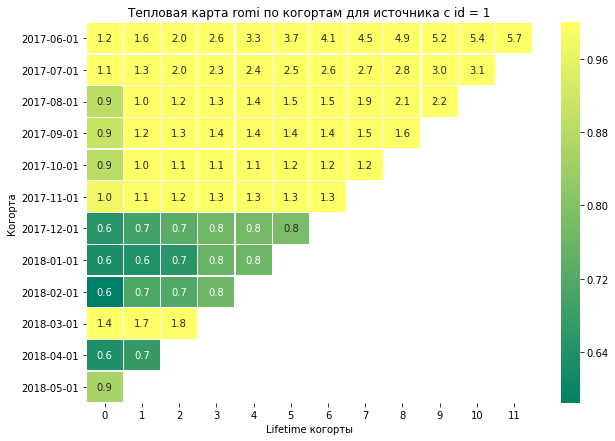

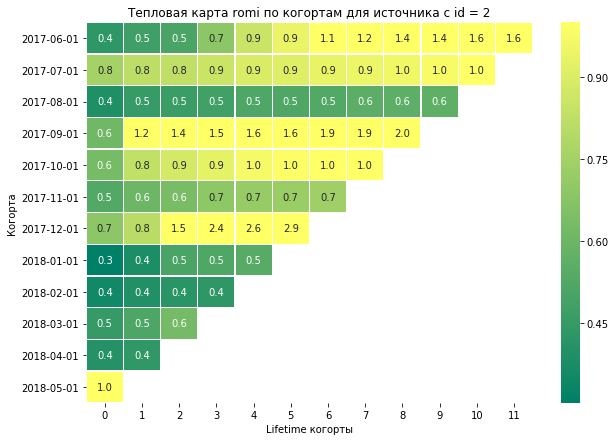

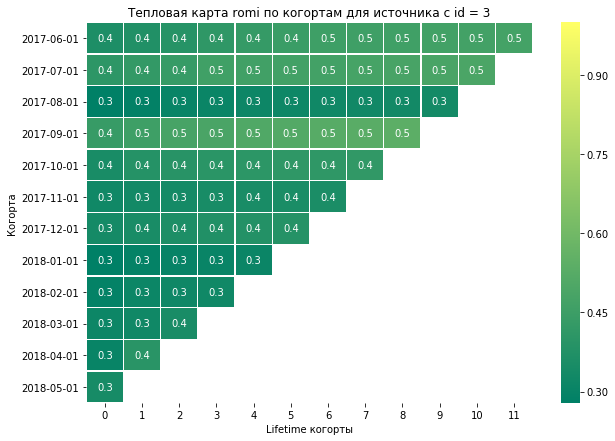

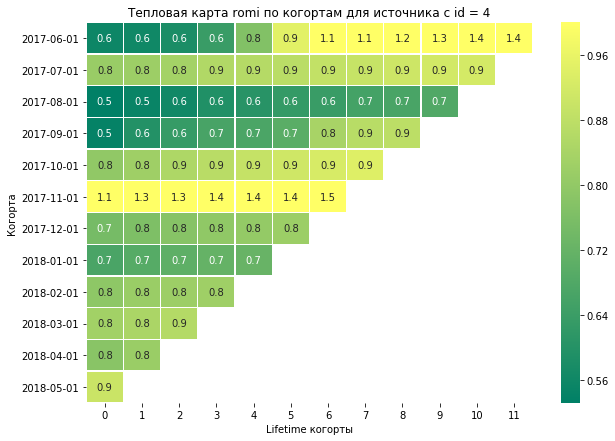

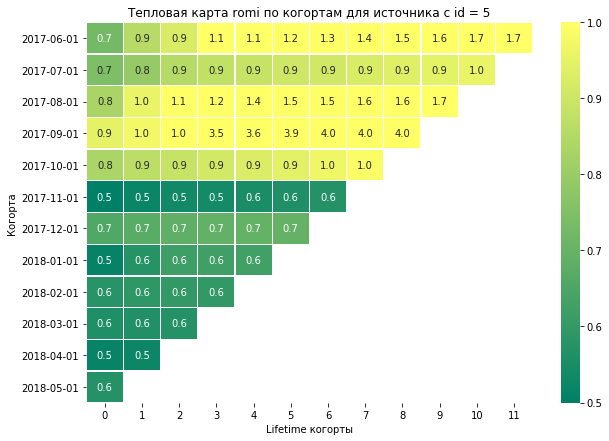

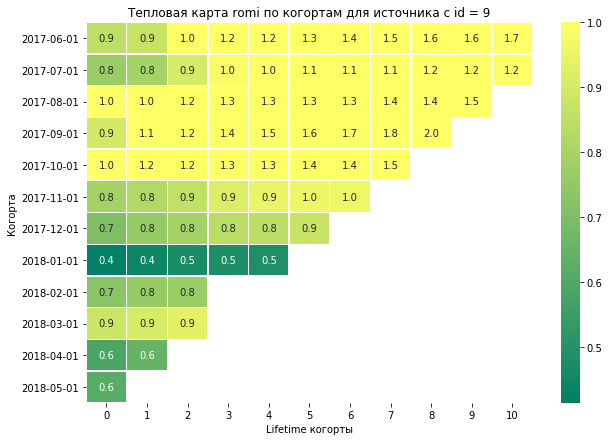

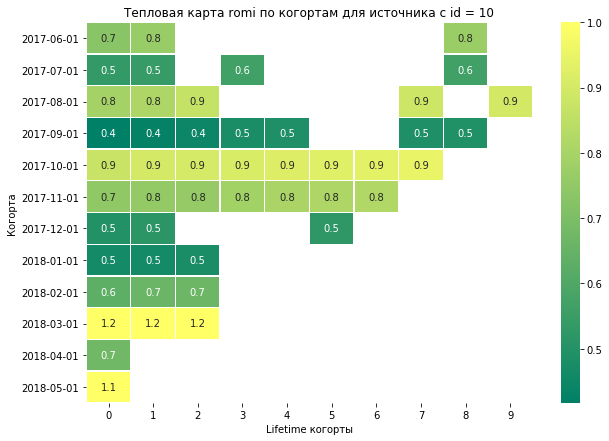

In [207]:
# Тепловая карта romi для каждого типа источника рекламы
for i in orders_cohorts_per_source['source_id'].unique():
    pivot = orders_cohorts_per_source.query('source_id == @i').pivot(
        index = 'first_order_month',
        columns='cohort_lifetime',
        values='romi').cumsum(axis=1)
    plt.figure(figsize=(10, 7))
    sns.heatmap(pivot, annot=True, fmt='.1f', vmax=1,
                linewidths=0.3, cmap = 'summer',
                yticklabels = pivot.index.date)
    plt.title('Тепловая карта romi по когортам для источника c id = {}'.format(i))
    plt.xlabel('Lifetime когорты')
    plt.ylabel('Когорта')
    plt.show()

<a id='step2.3.4'></a>
### Вывод

<span style="color:#2B8E6A">**Расходы на маркетинг**</span>    
Всего на маркетинг за исследуемый период было потрачено **329 131,62 y.e**., тогда как общая сумма выручки составила **252 057,2 у.е.** за этот же период: затраты на маркетинг сильно превышают полученную выручку.  
Самыми затратными оказались осенне-зимние месяцы, тогда как именно вы эти месяцы самая низкая посещаемость и выручка. Кажется, применяемые маркетинговые стратегии в эти месяцы сработали не очень хорошо.


<span style="color:#2B8E6A">**Стоимость привлечения одного клиента (CAC)**</span>    
Самые дорогие источники рекламы оказались источники с идентификаторами **3** и **2**, однако по количеству привлеченных покупателей 2-ой источник далеко не на первом месте, в то время как 3-ий также лидирует по числу привлеченных клиентов.
4-ый источник привлечения кажется наиболее успешным, т.к. по затратам на привлечение он занимает 5-ое место, в то время как количество привлеченных покупателей почти наравне с 3-им источником.   
Самым затратным оказался август для 3 источника рекламы.  
Однако, чтобы сделать выводы, необходимо посмотреть на окупаемость для каждого источника.


<span style="color:#2B8E6A">**Окупаемость расходов на маркетинг (ROMI)**</span>    
1, 9 и 5 источники кажутся одними из самых удачных, т.к. за 2017 год окупаемость затрат на рекламу происходила уже в первые (а иногда и в самый первый) месяцы жизни когорт.
Однако для каждого из этих источников были и провальные когорты (в 2018 году), которые не окупились за рассматриваемый период. 

Расчет ROMI подтвердил, что 3 источник является самым провальным: он не окупился ни для одной когорты на протяжении всей ее жизни.

На окупаемость очень сильно влияет первый месяц жизни когорты - если ROMI достаточно низкий в этот месяц, то источник обычно не окупается.
Так, например, январская когорта за изучаемый период не окупилась ни для одного источника рекламы. 



<a id='step3'></a>
## Шаг 3. Общий вывод

По результатам проведенного анализа можно сделать вывод, что не все маркетинговые стратегии сработали успешно: расходы на маркетинг превысили выручку с клиентов.

Есть несколько проблемных мест, на которые стоит обратить внимание:
1. Больше всего было потрачено на источник рекламы с id = 3, в то время как окупаемость этого источника самая низкая. Возможно, стоить снизить затраты на данный источник рекламы, а лучше присмотреться к источникам 1, 5 и 9.
2. В осенне-зимний период был сильный прирост в количествах посещений, но при этом снизился Retention Rate для осенне-зимних когорт, а также LTV первого месяца. 
3. Почти 84% посещающих сайт уникальных пользователей ни разу за исследуемый период не совершали покупки.
4. Был отмечен резкий рост пользователей в октябре 2017 года, после чего, начиная с марта, произошло резкое снижение в количестве пользователей. Необходимо понять, типичное ли это поведение пользователей по сезонам, или что могло повлиять на такой исход.

Удачные стратегии:
1. Был огромный скачок в посещениях и среднем чеке в Черную пятницу (24.11.2017): по всей видимости, акции, устраиваемые в этот день помогли привлечь большое количество пользователей. Возможно, стоит проводить аналогичные акции в менее успешные периоды.
2. Пользователи сентябрьской когорты показали себя наиболее прибыльными из-за необычного всплеска на третьем месяце жизни когорты (в декабре). Вероятно, для них проводились какие-то акции при совершении первой покупки
